In [1]:
import math
import os
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import xml.etree.ElementTree as ET
from scipy import optimize
from tqdm import tqdm

from IPython.display import display, Video
from mirai.utils import *
from mirai.utils import MovieIterator, make_video
from omnicv import fisheyeImgConv

# Pipeline

## Input Setup

In [2]:
input_video = '/ws/ball_detection/nbs/uchida_folder/input/IMG_0400.mov'
output_dir = '/data/outputs/pipeline'

In [3]:
os.makedirs(output_dir, exist_ok=True)

movie_iterator = MovieIterator(input_video)
fps = movie_iterator.video_fps
imgs = [x for x in movie_iterator]

# make output directories
frame_dir = os.path.join(output_dir, 'frames')
flo_dir = os.path.join(output_dir, 'flo')


# convert video to frames
os.makedirs(frame_dir, exist_ok=True)
os.system(f"ffmpeg -r 1 -i {input_video} -r 1 {os.path.join(frame_dir, '%06d.png')}")
img_paths = sorted(os.listdir(frame_dir))
print(len(img_paths))

Unexpected end.
944


## Load Annotation

In [4]:
annot_path = '/ws/ball_detection/nbs/uchida_folder/input/xml_file_test/annotations_01.xml'
tree = ET.parse(annot_path)

bboxes_list_gt = []
root = tree.getroot()
assert len(root[2]) <= len(imgs), len(root[2])

xs_gt = []
ys_gt = []
ts_gt = []
for i in range(len(root[2])):
    xmin = float(root[2][i].attrib["xtl"])
    xmax = float(root[2][i].attrib["xbr"])
    ymax = float(root[2][i].attrib["ytl"])
    ymin = float(root[2][i].attrib["ybr"])

    xs_gt.append(xmin + (xmax-xmin)/2)
    ys_gt.append(ymin + (ymax-ymin)/2)        
    ts_gt.append(i)
    
xs_gt = np.asarray(xs_gt)
ys_gt = np.asarray(ys_gt)
ts_gt = np.asarray(ts_gt)

## Detection 

In [9]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')  #  P6 model

bboxes_list = []
for i, img in enumerate(tqdm(imgs)):

    results = model(img, size=movie_iterator.img_width, augment=True)
    row = results.pandas().xyxy[0]
    row['frame'] = i
    

    row = results.pandas().xyxy[0]
    balls = row[row['name']=='sports ball']
    
    frame_bboxes = []
    for _, ball in balls.iterrows():
        x1,y1,x2,y2 = ball[['xmin','ymin','xmax','ymax']].astype(int)
        frame_bboxes.append([x1,y1,x2,y2])
        
    bboxes_list.append(frame_bboxes)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
Fusing layers... 
Model Summary: 606 layers, 141755500 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 2021-7-5 torch 1.8.1+cu102 CUDA:0 (GeForce GTX 1080 Ti, 11178.5MB)

100%|██████████| 944/944 [10:16<00:00,  1.53it/s]


In [10]:
yolo_imgs = []
for i, img in enumerate(tqdm(imgs)):
    im_circle = img.copy()
    for bboxes in bboxes_list[i]:
        x1,y1,x2,y2 = bboxes

        cx = x1 + (x2 - x1) // 2
        cy = y1 + (y2 - y1) // 2
        r = ((x2 - x1) + (y2 - y1)) // 4 

        im_circle = cv2.circle(im_circle, (cx, cy), 0, (0,0,255), thickness=5)
        im_circle = cv2.circle(im_circle, (cx, cy), r, (0,0,255), thickness=1)

    yolo_imgs.append(im_circle)

100%|██████████| 944/944 [00:01<00:00, 568.58it/s]


In [11]:
make_video(yolo_imgs, fps, os.path.join(output_dir, 'yolo_result.mp4'))

  0%|          | 0/944 [00:00<?, ?it/s]

Find your images and video at /data/outputs/pipeline/yolo_result.mp4


In [11]:
xs, ys, ts = [], [], []

for i, frame_bboxes in enumerate(bboxes_list):
    for bboxes in frame_bboxes:
        xs.append(bboxes[0] + (bboxes[2]-bboxes[0])/2)
        ys.append(bboxes[1] + (bboxes[3]-bboxes[1])/2)        
        ts.append(i)
        
xs = np.asarray(xs)
ys = np.asarray(ys)
ts = np.asarray(ts)

### Plot Result And Ground Truth

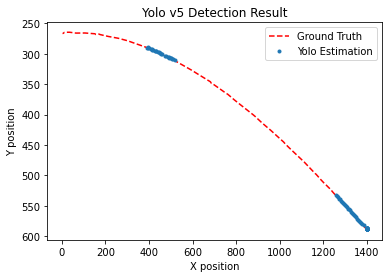

In [13]:
%matplotlib inline
plt.plot(xs_gt, ys_gt, 'r--', xs, ys, '.')

plt.legend(['Ground Truth', 'Yolo Estimation'], loc='upper right')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Yolo v5 Detection Result')

plt.gca().invert_yaxis()
plt.show()

---

## Optical Flow

## Interpolation (Model Fitting)

### Start Point Detection

625


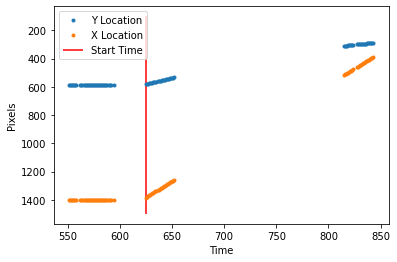

In [14]:
def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, ts, -xs)
ct, cx = p[0], p[1]
s = np.sqrt((ts - ct)**2 + (-xs - cx)**2).argmin()

print(ts[s])
plt.plot(ts, ys, '.', label='Y Location')
plt.plot(ts, xs, '.', label='X Location')
plt.vlines(ts[s], 100, 1500, label='Start Time', color='red')
plt.gca().invert_yaxis()
plt.xlabel('Time')
plt.ylabel('Pixels')
plt.legend()
plt.show()

## 2nd degree polynomial fitting

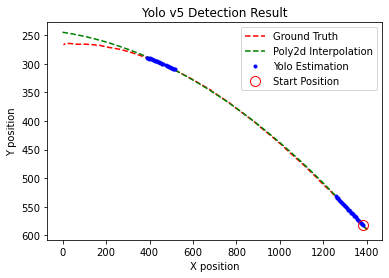

In [15]:
z1 = np.polyfit(ts[s:], xs[s:], 1)
p1 = np.poly1d(z1)

z2 = np.polyfit(xs[s:], ys[s:], 2)
p2 = np.poly1d(z2)

xp = np.linspace(0, 1400, 1400)
yp = p2(xp)

plt.plot(xs_gt, ys_gt, 'r--', xp, yp, 'g--', xs[s:], ys[s:], 'b.')
plt.plot(xs[s], ys[s], 'ro', mfc='none', ms=10)

plt.legend(['Ground Truth', 'Poly2d Interpolation', 'Yolo Estimation', 'Start Position'], loc='upper right')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Yolo v5 Detection Result')

plt.gca().invert_yaxis()
plt.show()

In [16]:
xsi, ysi, tsi = [], [], []

for i in range(ts[s], len(movie_iterator)):
    tsi.append(i)
    xsi.append(p1(i))
    ysi.append(p2(p1(i)))        

In [17]:
r_list = []
for frame_bboxes in bboxes_list:
    for bboxes in frame_bboxes:
        if bboxes!= []:
            x1,y1,x2,y2 = bboxes
            r_list.append((x2-x1)/2)
            r_list.append((y2-y1)/2)
r_mean = np.mean(r_list)  
r_mean = np.round(r_mean).astype(int)
r_mean

8

In [18]:
yolo_interp_imgs = []
for i, im in enumerate(tqdm(imgs)):
    im_circle = im.copy()
    if i < ts[s]:
        yolo_interp_imgs.append(im_circle)
        continue
    
    cx = np.round(p1(i)).astype(int)
    cy = np.round(p2(cx)).astype(int)

    im_circle = cv2.circle(im_circle, (cx, cy), 0, (0,0,255), thickness=5)
    im_circle = cv2.circle(im_circle, (cx, cy), r_mean, (0,0,255), thickness=1)

    yolo_interp_imgs.append(im_circle)
    
make_video(yolo_interp_imgs, 25, 'yolo_result_interp.mp4')

1569it [00:02, 568.37it/s]                        


  0%|          | 0/944 [00:00<?, ?it/s]

Find your images and video at yolo_result_interp.mp4


## Separability Filter

In [49]:
def expand_dim_to_3(arr):
    if arr.ndim == 2:
        return np.expand_dims(arr, axis=-1)
    elif arr.ndim == 3:
        return arr
    else:
        raise ValueError()
        

def intensity_region_1(img, cx, cy, r, return_pixels=False):
    width = img.shape[0]
    height = img.shape[1]
    mask = np.zeros((width, height), np.uint8)

    circle_img = cv.circle(mask,(cx,cy),r, (255,255,255), thickness=-1)
    masked_data = cv.bitwise_and(img, img, mask=circle_img)[cy-r:cy+r+1, cx-r:cx+r+1]

    masked_data = expand_dim_to_3(masked_data)
    pixels = masked_data[masked_data.sum(axis=2)!=0]
    n_pixels = len(pixels)
    
    
    if return_pixels:
        return pixels 
    return pixels.mean(axis=0).mean(), n_pixels 
    
def intensity_region_2(img, cx, cy, r_in, r_out, return_pixels=False):

    assert r_in < r_out
    width = img.shape[0]
    height = img.shape[1]
    mask_r_out, mask_r_in = np.zeros((width, height), np.uint8), np.zeros((width, height), np.uint8)

    mask_r_out = cv.circle(mask_r_out,(cx,cy),r_out, (255,255,255), thickness=-1)
    mask_r_in = cv.circle(mask_r_in,(cx,cy),r_in, (255,255,255), thickness=-1)
    mask = cv.bitwise_and(mask_r_out, mask_r_out, mask=cv.bitwise_not(mask_r_in))
    
    masked_data = cv.bitwise_and(img, img, mask=mask)
    masked_data = expand_dim_to_3(masked_data)

    pixels = masked_data[masked_data.sum(axis=2)!=0]
    n_pixels = len(pixels)
    if return_pixels:
        return pixels 

    return pixels.mean(axis=0).mean(), n_pixels 


def seperability_filter(img, r_in, r_out):
    width, height = img.shape[:2]
    result = np.zeros((width, height))
    
    for x in range(r_out, width-r_out):
        for y in range(r_out, height-r_out):
            
            r1_pixels = intensity_region_1(img, x, y, r_in, True)
            r2_pixels = intensity_region_2(img, x, y, r_in, r_out, True)
            
            r1_mean = r1_pixels.mean(axis=0, keepdims=True).T
            r2_mean = r2_pixels.mean(axis=0, keepdims=True).T
            
            n_r1 = len(r1_pixels)
            n_r2 = len(r2_pixels)
            
            n_overall = n_r1 + n_r2
            overall_mean = r1_mean * n_r1/n_overall + r2_mean * n_r2/n_overall
                        
            S_B = n_overall * (r1_mean - overall_mean).dot((r1_mean - overall_mean).T) + \
                n_overall * (r2_mean - overall_mean).dot((r2_mean - overall_mean).T)
            
            
            S_T = np.cov(np.concatenate([r1_pixels, r2_pixels]).T)
                        
            if S_B.size==1:
                result[x,y] = S_B / S_T
            else:
                result[x,y] = np.trace(S_B) / np.trace(S_T)
                
    return result

### Visual Demonstration of Seperability Filter

100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


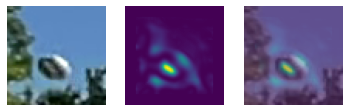

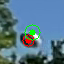

In [106]:
i = 880
im = imgs[i].copy()

im_cx = int(xsi[tsi.index(i)])
im_cy = int(ysi[tsi.index(i)])

r_in = 10
r_out = 16

m = int(r_mean * 4)
imc = im[im_cy-m:im_cy+m, im_cx-m:im_cx+m]

cx, cy = m, m

r_in_min , r_in_max = r_mean-2, r_mean+2
r_out_max = 16

results = []
for r_in in tqdm(range(r_in_min, r_in_max+1)):
    sep = np.stack(
        [seperability_filter(imc, r_in, r_out) for r_out in range(r_in + 1, r_out_max+1)]
    ).max(axis=(0))
    results.append(sep)

r_idx, cx_refine, cy_refine = np.unravel_index(np.argmax(results), np.shape(results))  
r_refine = range(r_mean-2, r_mean+2)[r_idx]

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(cv2.cvtColor(imc, cv2.COLOR_BGR2RGB))
ax1.axis('off')
ax2.imshow(results[r_idx].T)
ax2.axis('off')
ax3.imshow(cv2.cvtColor(imc, cv2.COLOR_BGR2RGB), alpha=0.8)
ax3.imshow(results[r_idx].T, alpha=0.5)
ax3.axis('off')
plt.show()

im_circle_refine = imc.copy()
im_circle_refine = cv.circle(im_circle_refine, (cx_refine, cy_refine), 0, (0,0,255), thickness=5)
im_circle_refine = cv.circle(im_circle_refine, (cx_refine, cy_refine), r_refine, (0,0,255), thickness=1)

im_circle_refine = cv.circle(im_circle_refine, (cx, cy), 0, (0,255,0), thickness=5)
im_circle_refine = cv.circle(im_circle_refine, (cx, cy), r_mean, (0,255,0), thickness=1)

cv2pil(im_circle_refine)
# print(intensity_region_1(imc, cx, cy, r_in, return_pixels=False))
# print(intensity_region_1(imc, cx, cy, r_in, return_pixels=True).shape)
# print(intensity_region_2(imc, cx, cy, r_in, r_out))

### Full Image

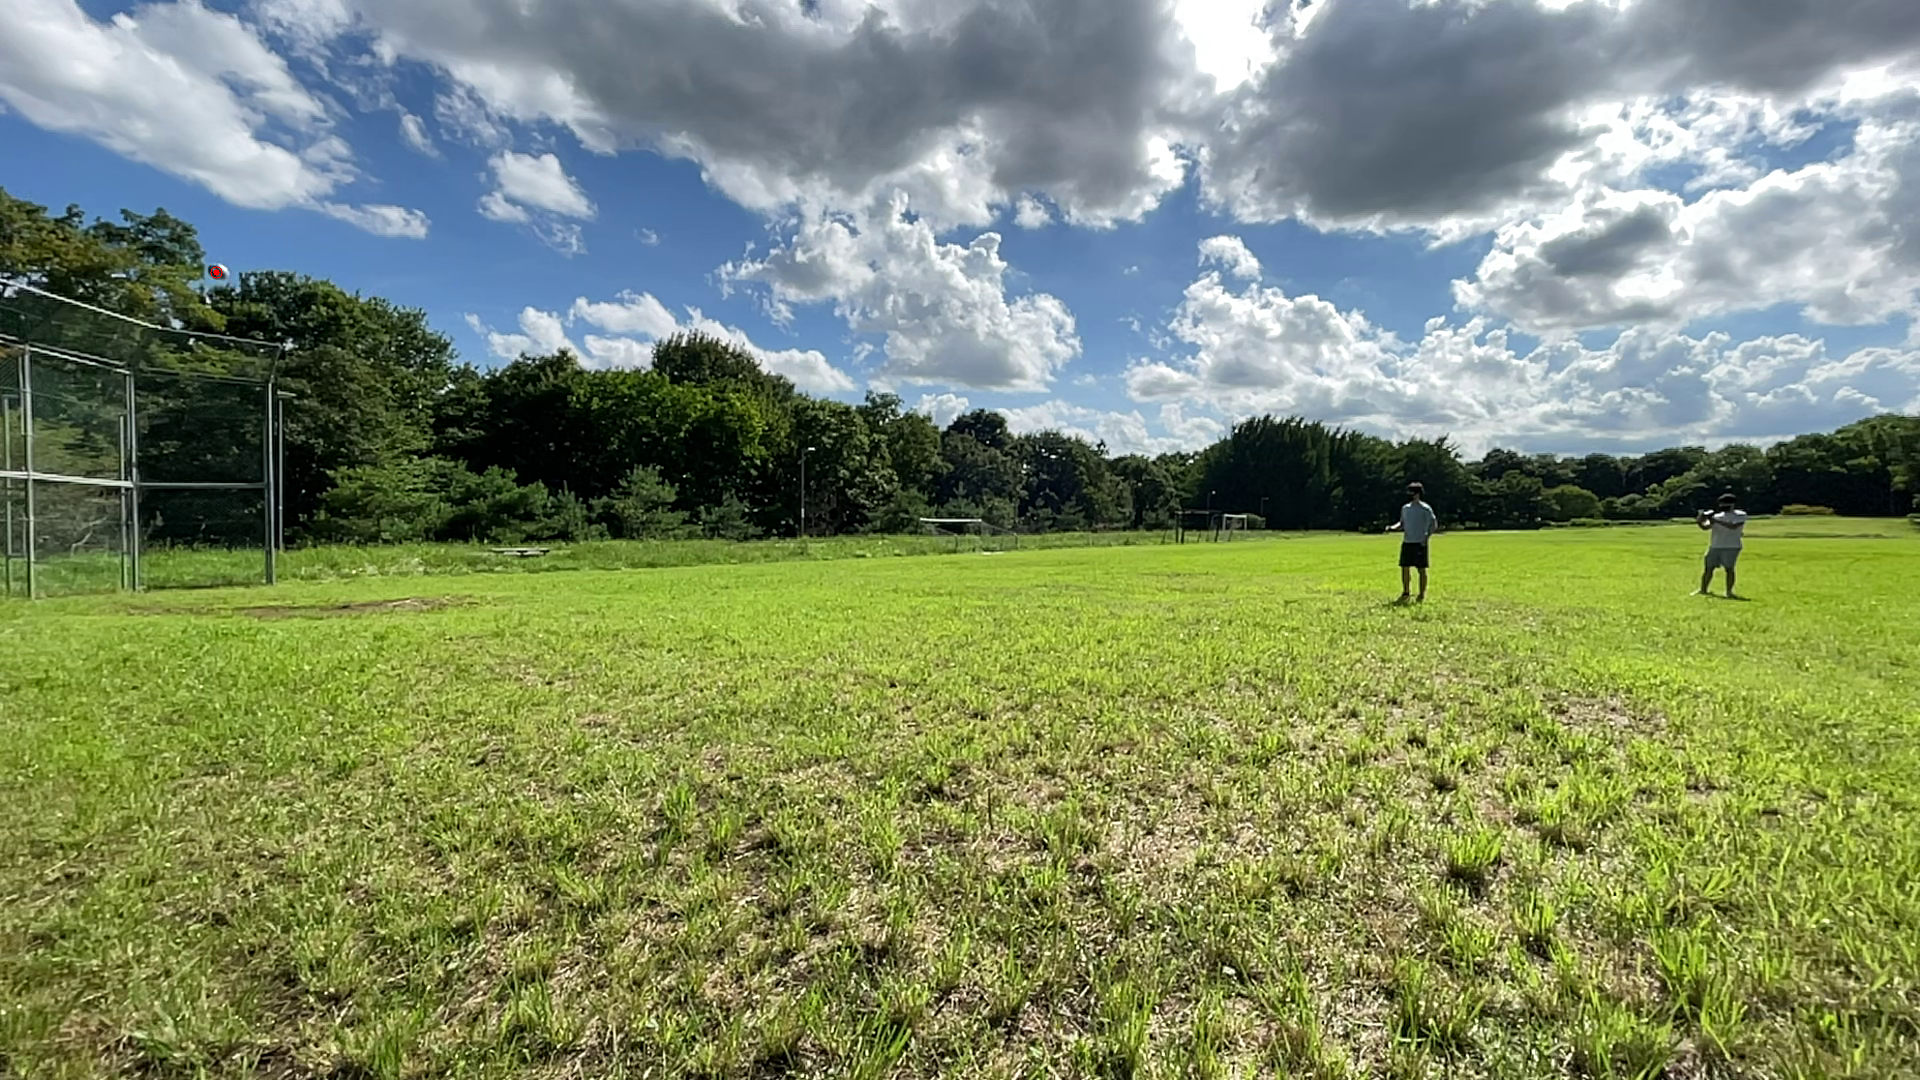

In [108]:
im_circle_refine = im.copy()
im_circle_refine = cv.circle(im_circle_refine, (cx_refine+im_cx-m, cy_refine+im_cy-m), 0, (0,0,255), thickness=5)
im_circle_refine = cv.circle(im_circle_refine, (cx_refine+im_cx-m, cy_refine+im_cy-m), r_refine, (0,0,255), thickness=1)
cv2pil(im_circle_refine)

### Video

In [127]:
r_in_min , r_in_max = r_mean-2, r_mean+3
r_out_max = 16
m = int(r_mean * 4)

sf_results = []
for i, im in enumerate(tqdm(imgs)):
    imc = im.copy()
    if i < ts[s]:
        sf_results.append(imc)
        continue
    
    im_cx = int(xsi[tsi.index(i)])
    im_cy = int(ysi[tsi.index(i)])
    imcut = imc[im_cy-m:im_cy+m, im_cx-m:im_cx+m]

    results = []
    for r_in in range(r_in_min, r_in_max):
        sep = np.stack(
            [seperability_filter(imcut, r_in, r_out) for r_out in range(r_in + 1, r_out_max+1)]
        ).max(axis=(0))
        results.append(sep)

    r_idx, cx_refine, cy_refine = np.unravel_index(np.argmax(results), np.shape(results))  
    r_refine = range(r_in_min , r_in_max)[r_idx]
    
    imc = cv.circle(imc, (cx_refine+im_cx-m, cy_refine+im_cy-m), 0, (0,0,255), thickness=5)
    imc = cv.circle(imc, (cx_refine+im_cx-m, cy_refine+im_cy-m), r_refine, (0,0,255), thickness=1)


    sf_results.append(imc)

make_video(sf_results, fps, 'sf_results.mp4')

 98%|█████████▊| 922/944 [1:59:47<02:51,  7.80s/it]  


ValueError: attempt to get argmax of an empty sequence

In [126]:
make_video(sf_results, fps, 'sf_results.mp4')

  0%|          | 0/922 [00:00<?, ?it/s]

Find your images and video at sf_results.mp4


### Optical Flow

In [16]:
backSub = cv.createBackgroundSubtractorMOG2()
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))

applied = []
for frame in tqdm(MovieIterator('./demo_kick.mp4')):
    fgmask = backSub.apply(frame)
    fgmask = cv.morphologyEx(fgmask, cv.MORPH_OPEN, kernel)
    applied.append(cv2.cvtColor(fgmask, cv2.COLOR_GRAY2BGR))


100%|██████████| 844/844 [00:49<00:00, 16.99it/s]


In [17]:
make_video(applied, 25, 'fgmask.mp4')

  0%|          | 0/844 [00:00<?, ?it/s]

Find your images and video at fgmask.mp4


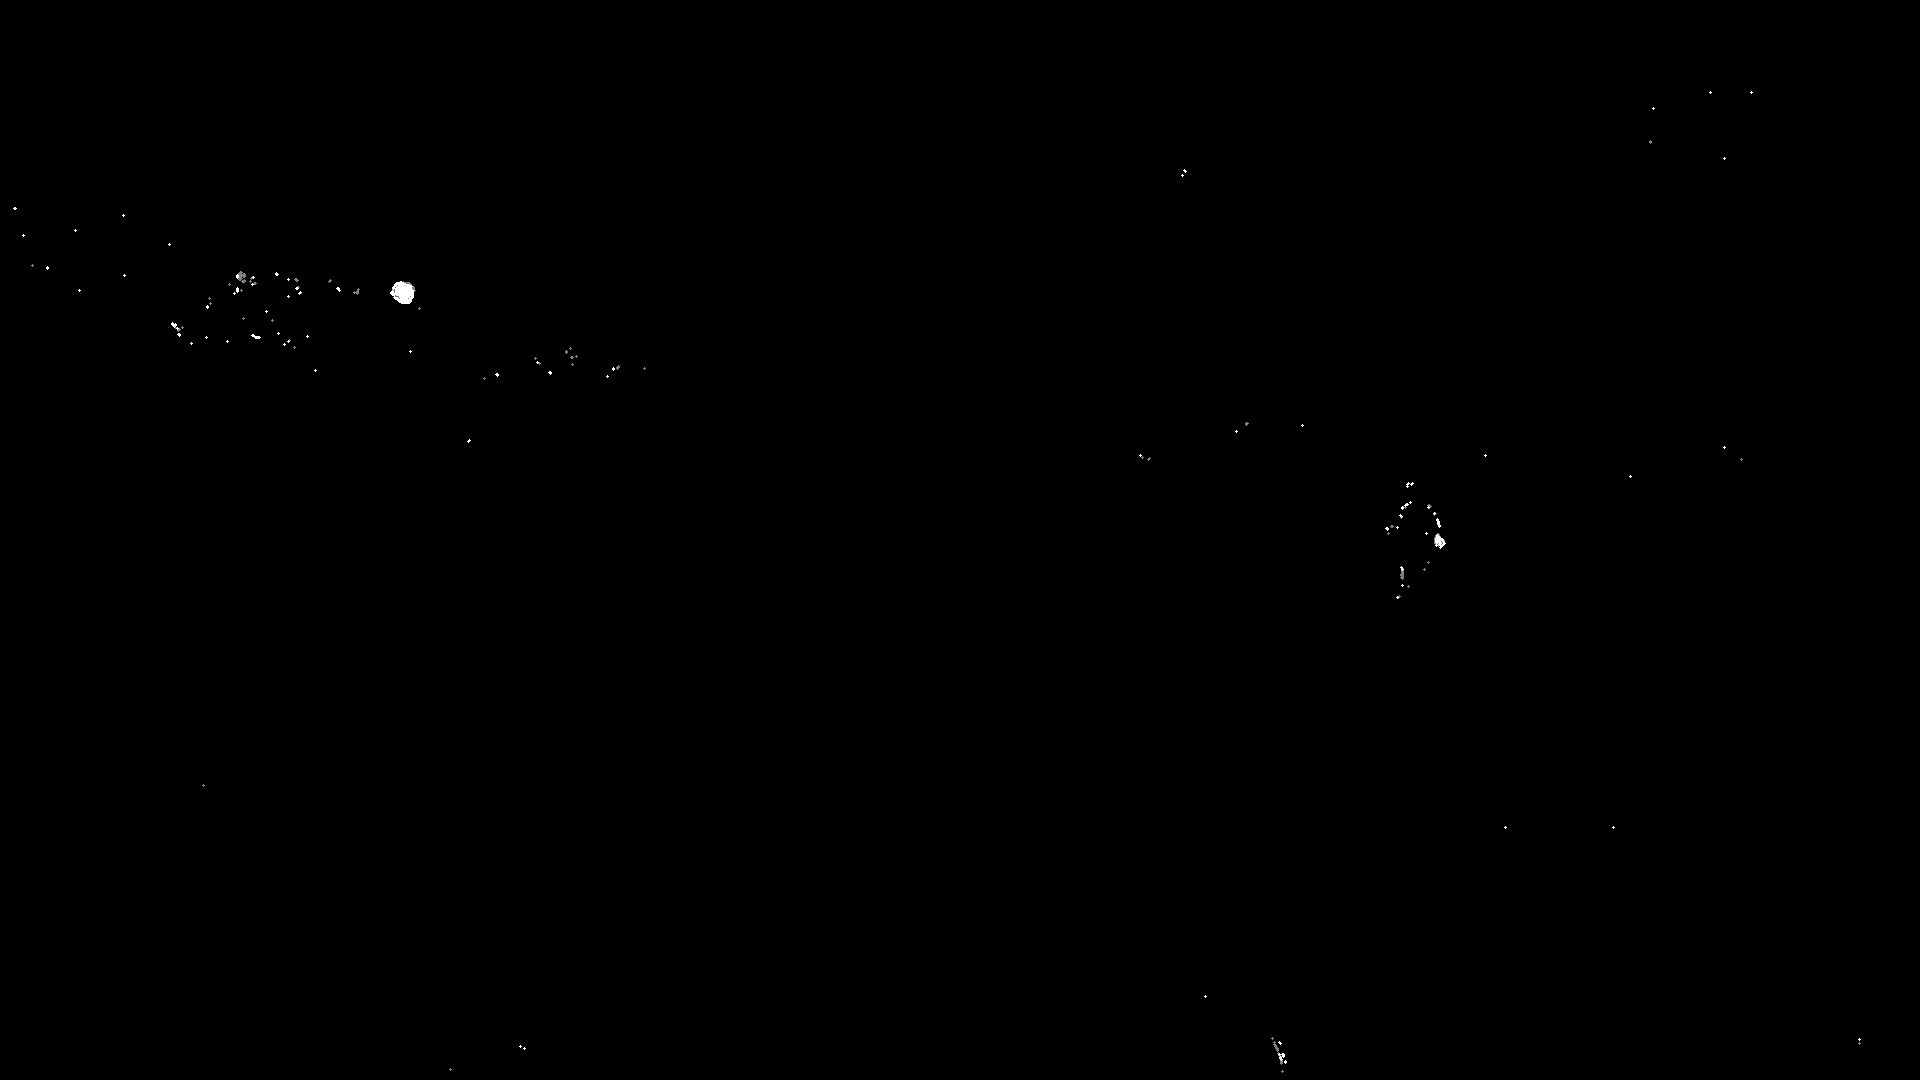

In [28]:
app = applied[751].copy()
cv2pil(app)